In [1]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

0    22.54
1   -17.46
2   -26.46
3    11.54
4     6.54
Name: x, dtype: float64

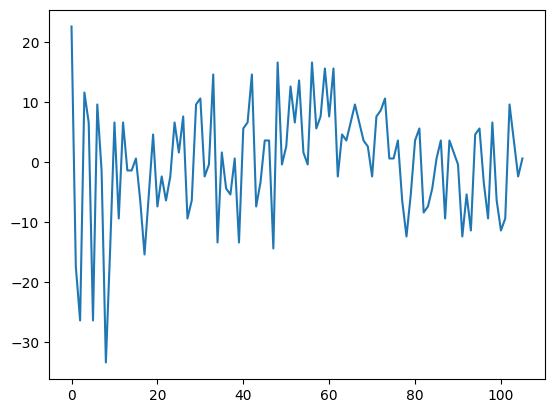

In [5]:
df = pd.read_csv('data/Annual_rainfall_eastern_USA_1817_1922.csv')
df = df['x']

df.plot()
df.head()

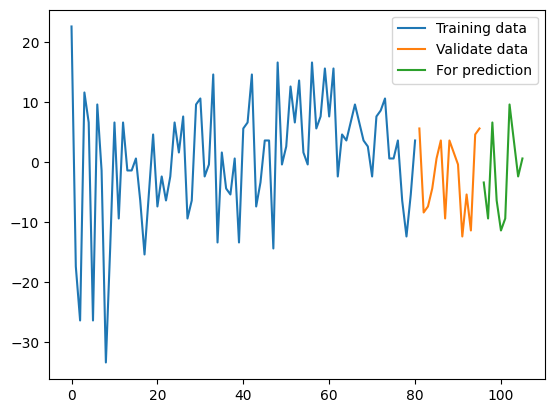

In [6]:
# Определяем размеры выборок
ln = len(df)
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# Делим данные на обучающую, валидационную и тестовую выборки
train_df = df[df.index<= train_cutoff]
validate_df = df[(df.index> train_cutoff) & (df.index<= validate_cutoff)]
forecast_df = df[df.index> validate_cutoff]

# Выводим график данных
plt.plot(train_df.index, train_df, label='Training data')
plt.plot(validate_df.index, validate_df, label='Validate data')
plt.plot(forecast_df.index, forecast_df, label='For prediction')
plt.legend()
plt.show()


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

def create_features(data, lag_range, rolling_range):
    # Создаем DataFrame для хранения признаков
    features = pd.DataFrame(index=data.index)

    # Создаем признаки на основе лагов
    for lag in lag_range:
        features[f'lag_{lag}'] = data.shift(lag)

    # Создаем признаки на основе скользящих статистик
    for window in rolling_range:
        features[f'rolling_mean_{window}'] = data.rolling(window=window).mean()
        features[f'rolling_std_{window}'] = data.rolling(window=window).std()

    return features

# Определяем диапазоны лагов и скользящих окон
lag_range = range(1, 4)
rolling_range = range(2, 5)

# Создаем признаки
features = create_features(df, lag_range, rolling_range)

# Удаляем строки с пропущенными значениями
features.dropna(inplace=True)

# Разделяем данные на обучающую и тестовую выборки
train_features = features[features.index <= train_cutoff]
validate_features = features[(features.index > train_cutoff) & (features.index <= validate_cutoff)]

# Обучаем модели дерева решений и случайного леса на новых признаках
tree_model = DecisionTreeRegressor()
tree_model.fit(train_features, train_df.loc[train_features.index])
forest_model = RandomForestRegressor()
forest_model.fit(train_features, train_df.loc[train_features.index])

# Предсказываем значения на тестовом наборе данных
tree_predictions = tree_model.predict(validate_features)
forest_predictions = forest_model.predict(validate_features)


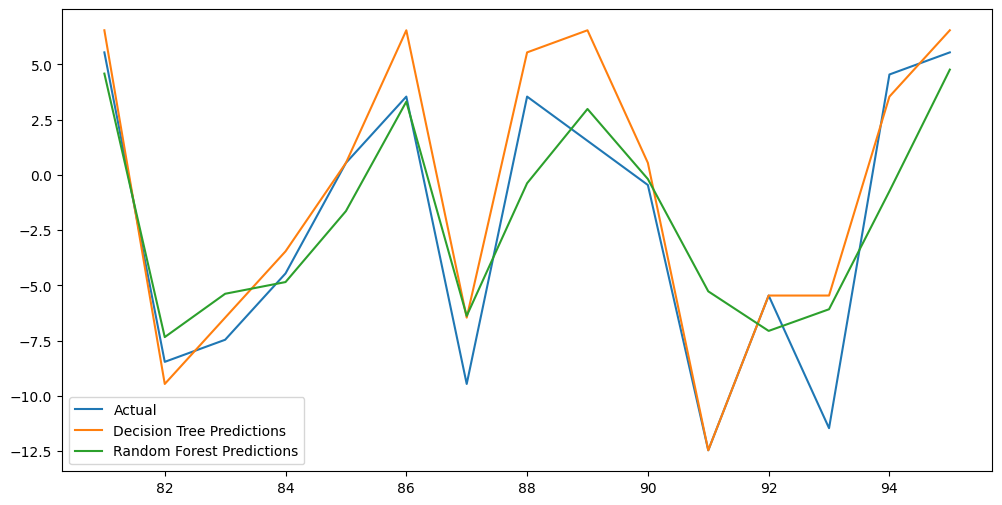

In [9]:
# График предсказаний дерева решений и случайного леса
plt.figure(figsize=(12,6))
plt.plot(validate_df.index, validate_df, label='Actual')
plt.plot(validate_df.index, tree_predictions, label='Decision Tree Predictions')
plt.plot(validate_df.index, forest_predictions, label='Random Forest Predictions')
plt.legend()
plt.show()


In [10]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# Оцениваем метрики
print("Decision Tree")
print("RMSE:", np.sqrt(mean_squared_error(validate_df, tree_predictions)))
print("MAPE:", mean_absolute_percentage_error(validate_df, tree_predictions))
print("MAE:", mean_absolute_error(validate_df, tree_predictions))
print("SMAPE:", smape(validate_df, tree_predictions))
print("R2: ", r2_score(validate_df, tree_predictions))

print("Random Forest")
print("RMSE:", np.sqrt(mean_squared_error(validate_df, forest_predictions)))
print("MAPE:", mean_absolute_percentage_error(validate_df, forest_predictions))
print("MAE:", mean_absolute_error(validate_df, forest_predictions))
print("R2: ", r2_score(validate_df, forest_predictions))
print("SMAPE:", smape(validate_df, forest_predictions))

Decision Tree
RMSE: 2.4494897427831783
MAPE: 0.582101505008245
MAE: 1.7333333333333334
SMAPE: 42.973039392226006
R2:  0.8452899381159752
Random Forest
RMSE: 3.1638204753114563
MAPE: 0.6914819432417905
MAE: 2.3933333333333326
R2:  0.7418982351592938
SMAPE: 69.96533648206251


In [11]:
from sklearn.ensemble import IsolationForest

# Обучаем модель изолированного дерева
iso_forest = IsolationForest(contamination=0.1)
iso_forest.fit(df.values.reshape(-1, 1))

# Предсказываем выбросы
outliers = iso_forest.predict(df.values.reshape(-1, 1))

# Выводим индексы выбросов
outlier_indices = df.index[outliers == -1]
print("Outlier indices:", outlier_indices)

Outlier indices: Index([0, 1, 2, 3, 5, 8, 17, 48, 51, 53, 56], dtype='int64')


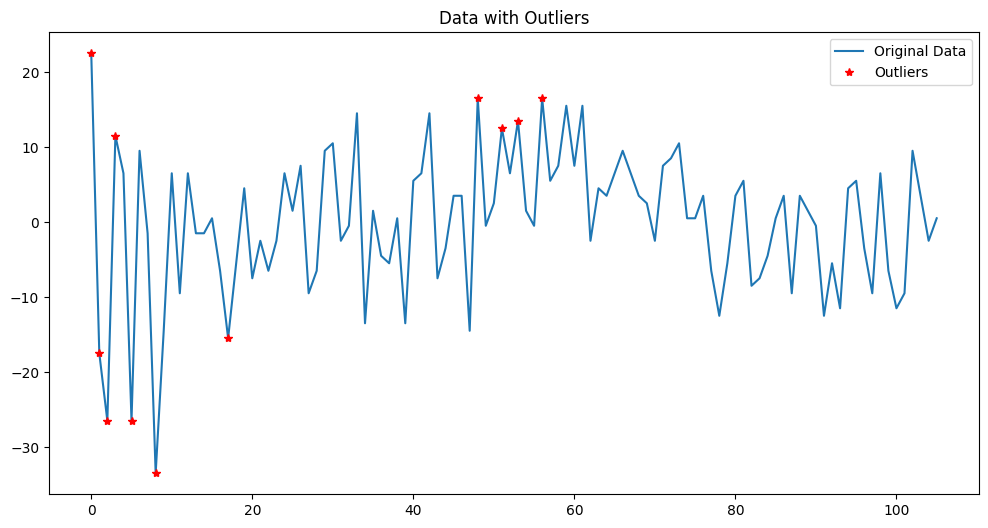

In [12]:
# График данных с выбросами
plt.figure(figsize=(12,6))
plt.plot(df, label='Original Data')
plt.plot(outlier_indices, df[outlier_indices], 'r*', label='Outliers')
plt.legend()
plt.title('Data with Outliers')
plt.show()